In [1]:
import numpy as np


from time import time
from matplotlib import pyplot
from pandas import DataFrame
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

## oldschool backprop
 * Create, train and evaluate feed forward neural networks, as it was described in the 1986 paper - [learning representations by back-propagating errors](https://www.iro.umontreal.ca/~vincentp/ift3395/lectures/backprop_old.pdf).


* This code follows how backprop was described in the paper, meaning that derivatives are calculated per training example per node per layer, without any vectorization. That fact makes training very slow in comparison to modern implementations of neural networks.

* This project is a personal investigation into how it would have probably felt like to train a neural network before the age of GPU powered deep learning or efficient computing tricks.

* Next step is coding up a modern implementation of backprop taking advantage of matrix calculus and vectorization.

### overall structure

  - initialize model parameters

  - repeat until convergence
    - forward propagation 
    - cost computation
    - backward propagation
    - updating parameters
  - evaluate network

  - perform predictions

### weight initialization
 * The paper mentions random initialization for weights to break symmetry.
 * initializing all weights including biases to a random number with $N(0, 1)$ distribution

In [2]:
def initialize_parameters(layer_dims):

  parameters = {}

  num_layers = len(layer_dims) - 1

  for i in range(1, num_layers + 1):
    parameters['w' + str(i)] = np.random.randn(layer_dims[i], layer_dims[i-1])
    parameters['b' + str(i)] = np.random.randn(layer_dims[i], 1)

  return parameters

In [3]:
# testing
params = initialize_parameters([2, 4, 2])

for k in params:
  print(k, params[k].shape)

w1 (4, 2)
b1 (4, 1)
w2 (2, 4)
b2 (2, 1)


### Activation
* paper uses sigmoid function for non-linearity of all layers

In [4]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

### Forward pass
* forward pass is comprised of two steps
  - linear combination of units in previous layer + bias
$$
x_j^{[l]} = \sum_{i=1}^{n^{[l-1]}} w_{ji}^{[l]}.y_i^{[l-1]} + b_j^{[l]}
$$
  - non-linearity (aka activation)
  $$
y_j^{[l]} = \frac{1}{1 + e^{-x_j^{[l]}}}  
  $$

for any unit $j=1, 2, ..., n^{[l]}$ and for any layer $l=1, 2, ..., L$ .

In [5]:
def forward_prop(network_input, params):

  num_layers = int(len(params) / 2)

  cache = {}

  cache['y0'] = network_input

  for i in range(1, num_layers + 1):
    
    cache['x' + str(i)] = np.dot(params['w' + str(i)], cache['y' + str(i - 1)]) + params['b' + str(i)]
    cache['y' + str(i)] = sigmoid(cache['x' + str(i)])

  return cache['y' + str(num_layers)], cache

In [6]:
# testing
network_input = np.random.randn(2, 50)
network_output, cache = forward_prop(network_input, params)

for k in cache:
  print(k, cache[k].shape)

y0 (2, 50)
x1 (4, 50)
y1 (4, 50)
x2 (2, 50)
y2 (2, 50)


### Cost function
* total error or cost function is selected as follows,
$$
E = \frac{1}{2} \sum_c\sum_j(y_{j,c}^{L} - d_{j,c})^2
$$

where $c$ is the index over trining examples, $j$ index over units in the output layer of the network, and $d$ is the target value for out network.

In [7]:
def compute_cost(y, d):
  return (1/2) * np.sum(np.square(y - d))

In [8]:
# testing
E = compute_cost(
    np.array([1.3, -2.0]),
    np.array([4.1, 3.3])
)

assert E == (1/2) * ((1.3 - 4.1)**2 + (-2.0 - 3.3)**2)

##### Back Propagation
* back prop can be thought of it having 2 parts
  - starting back prop : starting backprop depends on the choice of cost function. Taking derivative of out cost function we get,
  $$
\frac{\partial{E}}{\partial{y^{[L]}}} = y^{[L]} - d .
  $$

  - back prop for one layer: having derivatives of cost w.r.t. $y^{[l]}$ we can compute derivatives of cost w.r.t. $y^{[l - 1]}$.
    
    - derivative of cost with respect to weights,
  $$
\frac{\partial{E}}{\partial{w^{[l]}_{ji}}} =  \frac{\partial{E}}{\partial{y^{[l]}_{j}}}.y_j^{[l]}.(1 - y_j^{[l]}).y_i^{[l-1]}
  $$
    - derivative of cost with respect to biases,
  $$
\frac{\partial{E}}{\partial{b^{[l]}_{j}}} =  \frac{\partial{E}}{\partial{y^{[l]}_{j}}}.y_j^{[l]}.(1 - y_j^{[l]})
  $$
    - derivative of activations of previous layers,
  $$
\frac{\partial{E}}{\partial{y^{[l-1]}_{i}}} = \sum_{j=1}^{n^{[l]}} \frac{\partial{E}}{\partial{y^{[l]}_{j}}}.y_j^{[l]}.(1 - y_j^{[l]}).w_{ji}^{[l]}
  $$

 * derivation of the formula are available in the "oldschool_backprop_math.pdf" in the project page repository.

In [9]:
def back_prop_layer(y, y_prev, dy, w):

  m = y.shape[-1]
  n = w.shape[0]
  n_prev = w.shape[1]

  dw = np.zeros((n, n_prev))
  db = np.zeros((n, 1))
  dy_prev = np.zeros((n_prev, m))


  for c in range(m):

    for j in range(n):
      for i in range(n_prev):
        dw[j][i] += dy[j][c] * y[j][c] * (1 - y[j][c]) * y_prev[i][c]


    for j in range(n):
      db[j] += dy[j][c] * y[j][c] * (1 - y[j][c])


    for i in range(n_prev):
      for j in range(n):
        dy_prev[i][c] += dy[j][c] * y[j][c] * (1 - y[j][c]) * w[j][i]


  return dw, db, dy_prev

In [10]:
def back_prop(d, cache, params):

  num_layers = int(len(params) / 2)
  grads = {}
  
  grads['dy' + str(num_layers)] = cache['y' + str(num_layers)] - d

  for i in range(num_layers, 0 , -1):
    grads['dw' + str(i)], grads['db' + str(i)], grads['dy' + str(i - 1)] = back_prop_layer(cache['y' + str(i)], cache['y' + str(i-1)], grads['dy' + str(i)], params['w' + str(i)])


  return grads

In [11]:
# testing
network_input = np.random.randn(2, 50)
d = np.random.randn(2, 50)
grads = back_prop(d, cache, params)

for k in grads:
  print(k, grads[k].shape)

dy2 (2, 50)
dw2 (2, 4)
db2 (2, 1)
dy1 (4, 50)
dw1 (4, 2)
db1 (4, 1)
dy0 (2, 50)


### Back Propagation
* to update our model's parameters we can use the basic gradient descent update,
$$
w_{ji}^{[l]} = w_{ji}^{[l]} - \alpha . \frac{\partial{E}}{\partial{w^{[l]}_{ji}}}
$$

and,

$$
b_{j}^{[l]} = b_{j}^{[l]} - \alpha . \frac{\partial{E}}{\partial{b^{[l]}_{j}}}
$$

where $\alpha$ is the learning rate.


In [12]:
def update_params(params, grads, learning_rate):

  params = params.copy()

  num_layers = int(len(params) / 2)

  for i in range(1, num_layers + 1):
    params['w' + str(i)] = params['w' + str(i)] - learning_rate * grads['dw' + str(i)]
    params['b' + str(i)] = params['b' + str(i)] - learning_rate * grads['db' + str(i)]

  return params

In [13]:
# testing
new_params = update_params(params, grads, 0.01)

for k in params:
  print(k, 'diff:', np.mean(np.abs(params[k] - new_params[k])))

w1 diff: 0.0025793571562101186
b1 diff: 0.010350695437698697
w2 diff: 0.01774112021665427
b2 diff: 0.05397967701350706


### Training
- two different approaches are mentioned in the paper
  - one is updating parameters after each training example this is now called "stochastic gradient descent" and is useful when we have a lot of input data, so much so that seeing the progress of training takes a long time but it will add some randomness to the process of training and loss curve will be noisy.
  - another method is updating after seeing the entire dataset this is now called "batch gradient descent" it will lead to a smoother loss curve but takes longer for each step to complete.

- for now we implements batch gradient descent.

In [14]:
def model(network_input, d, layer_dims, epochs = 1, learning_rate = 0.1, print_cost=True):

  costs = []
  params = initialize_parameters(layer_dims)
  
  for i in range(1, epochs + 1):
    # training loop
    network_output, cache = forward_prop(network_input, params)
    cost = compute_cost(network_output, d)
    grads = back_prop(d, cache, params)
    params = update_params(params, grads, learning_rate)

    # printing cost
    if i % 100 == 0 and print_cost:
      print(f'cost after epoch {i} - ', cost)
    costs.append(cost)


  return costs, params

In [15]:
# testing
network_input = np.random.randn(2, 50)
d = np.random.randn(2, 50)

costs, params = model(network_input, d, [2, 4, 2], epochs = 50)

### Predictiction
- prediction with the model consists of feeding the input to the model and reporting the output.

In [16]:
def predict(test_input, params):
  network_output, _ = forward_prop(test_input, params)
  return network_output

In [17]:
# testing
test_input = np.random.randn(2, 5)
predict(test_input, params)

array([[0.01507476, 0.00709433, 0.01461626, 0.00987076, 0.00768139],
       [0.26522885, 0.28327179, 0.22132728, 0.34673301, 0.23776847]])

### Evaluation
- evaluation of the model consists of reporting the cost and other measures of accuracy for a given input data. in this project evaluate() reports cost and accuracy of classification .

In [18]:
def evaluate(test_input, test_tagets, params):
  network_output, _ = forward_prop(test_input, params)

  # calculate cost
  cost = compute_cost(network_output, test_tagets)


  # calculate accuracy
  network_predictions = np.argmax(network_output, axis=0)
  target_values = np.argmax(test_tagets, axis=0)


  total = 0
  pos = 0
  for i in range(len(network_predictions)):
    if network_predictions[i] == target_values[i]:
      pos += 1
    total += 1

  accuracy = pos / total

  print('cost:', cost, ' - accuracy:', accuracy)

  return cost, accuracy

In [19]:
# testing
evaluate(network_input, d, params)

cost: 59.40603049809124  - accuracy: 0.64


(59.40603049809124, 0.64)

### Visualization
- we can visualize the training of the model by plotting changes of cost function over the period of training. optionally, we can include changes in cross validation loss to compare the two graphs.
- another visualization method is to plot decision boundary of a planar dataset to see how the model classifies between different classes.

In [20]:
def plot_costs(costs, val_costs=None):
  if not val_costs:
    plt.plot(costs)
    plt.title('cost per epoch')
    plt.xlabel('epoch')
    plt.ylabel('cost')
  else:
    raise NotImplementedError

  plt.show()

In [21]:
def plot_binary_dataset(X, y):


  min1, max1 = X[:, 0].min() - 0.25, X[:, 0].max() + 0.25
  min2, max2 = X[:, 1].min() - 0.25, X[:, 1].max() + 0.25
  
  row_ix = np.where(y == 0)
  plt.scatter(X[row_ix, 0], X[row_ix, 1], c='red')

  row_ix = np.where(y == 1)
  plt.scatter(X[row_ix, 0], X[row_ix, 1], c='blue')

  plt.xlim(min1, max1)
  plt.ylim(min2, max2)
  plt.xlabel('x1')
  plt.ylabel('x2')


  plt.show()

In [22]:
def plot_decision_boundary(dataset_input, dataset_targets, parameters):

  X, y = dataset_input, dataset_targets

  min1, max1 = X[:, 0].min() - 0.25, X[:, 0].max() + 0.25
  min2, max2 = X[:, 1].min() - 0.25, X[:, 1].max() + 0.25

  x1grid = np.arange(min1, max1, 0.1)
  x2grid = np.arange(min2, max2, 0.1)
  # create all of the lines and rows of the grid
  xx, yy = np.meshgrid(x1grid, x2grid)
  r1, r2 = xx.flatten(), yy.flatten()
  r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
  grid = np.hstack((r1,r2))

  # predict with model
  yhat = np.argmax(predict(grid.T, parameters), axis=0)
  zz = yhat.reshape(xx.shape)

  # plot decision boundary 
  ax = plt.contourf(xx, yy, zz, colors=['red', 'blue'], levels=[0,0.5,1], alpha = 0.5)

  # plot data points
  row_ix = np.where(y == 0)
  plt.scatter(X[row_ix, 0], X[row_ix, 1], c='red')

  row_ix = np.where(y == 1)
  plt.scatter(X[row_ix, 0], X[row_ix, 1], c='blue')

  plt.xlim(min1, max1)
  plt.ylim(min2, max2)
  plt.xlabel('x1')
  plt.ylabel('x2')


  plt.show()


### testing the model on different synthetic datasets.

In [23]:
def testing_on_dataset(X, y, layer_dims, epochs, learning_rate, print_cost=True):
  print('\n\n == Dataset == \n')
  plot_binary_dataset(X, y)

  print('\n\n == Training == \n')

  t_0 = time()
  costs, params = model(X.T, to_categorical(y).T, layer_dims,  epochs = epochs, learning_rate = learning_rate, print_cost=print_cost)
  training_time = time() - t_0

  print('\n\n == Evaluation == \n')
  cost, accuracy = evaluate(X.T,  to_categorical(y).T, params)
  print('\nTraining took %.2f seconds.' % training_time)

  print('\n\n == Visualization == \n')
  plot_costs(costs)
  print('\n')
  plot_decision_boundary(X, y, params)



 == Dataset == 



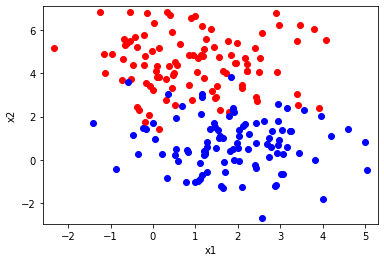



 == Training == 

cost after epoch 100 -  12.375031118691
cost after epoch 200 -  10.563136027274641


 == Evaluation == 

cost: 10.556284775290768  - accuracy: 0.94

Training took 78.75 seconds.


 == Visualization == 



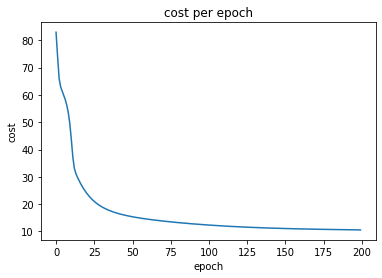

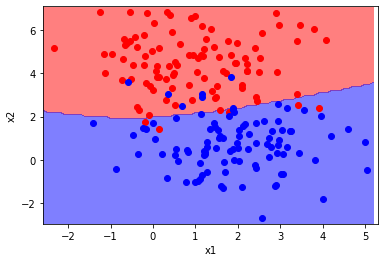

In [25]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=200, centers=2, cluster_std = 1.3, random_state=0)
testing_on_dataset(X, y, [2, 16, 16, 2], 200, 0.01)



 == Dataset == 



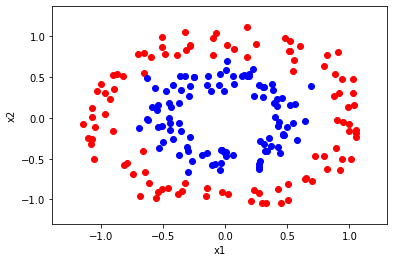



 == Training == 

cost after epoch 100 -  49.23132826597919
cost after epoch 200 -  47.578959317336796
cost after epoch 300 -  44.41500421511964
cost after epoch 400 -  38.98120213338241
cost after epoch 500 -  29.829133568760085


 == Evaluation == 

cost: 29.708473807806996  - accuracy: 0.885

Training took 347.85 seconds.


 == Visualization == 



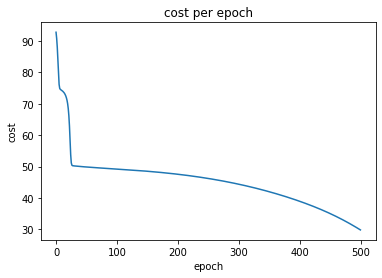

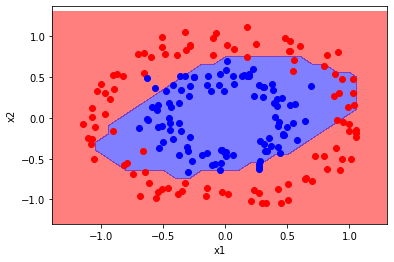

In [26]:
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=200, noise=0.1, factor=0.5)
testing_on_dataset(X, y, [2, 16, 16, 16, 2], 500, 0.005)



 == Dataset == 



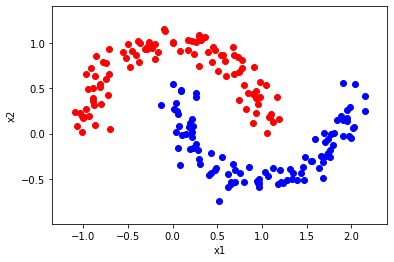



 == Training == 

cost after epoch 100 -  15.408567992825803
cost after epoch 200 -  13.1766837993326
cost after epoch 300 -  11.454757199251453
cost after epoch 400 -  9.604213506434721
cost after epoch 500 -  7.821887840281326


 == Evaluation == 

cost: 7.805198382886484  - accuracy: 0.95

Training took 675.04 seconds.


 == Visualization == 



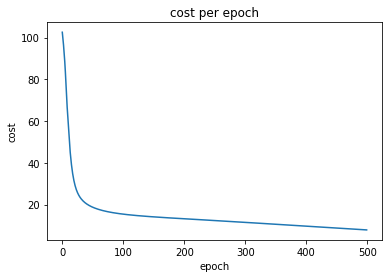

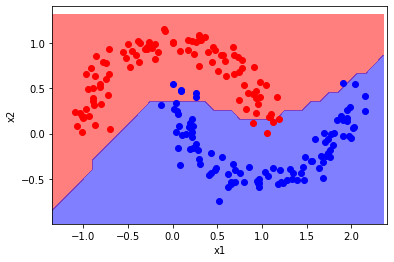

In [24]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=200, noise=0.1)
testing_on_dataset(X, y, [2, 32, 32, 2], 500, 0.005)